In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta

In [112]:
#UTILS 
def ret_metrics(daily_ret_df):
    start_date, end_date = daily_ret_df.index[[0,-1]]
    years = (end_date - start_date).days/365

    CAGR = (CGR[-1] + 1)**(1/years) - 1
    sharpe = daily_ret_df.mean()/daily_ret_df.std() 
    rolling_sharpe = daily_ret_df.rolling(window=126).mean()/daily_ret_df.rolling(window=126).std()
    print(f'CAGR: {np.round(100*CAGR,2)}%, Anual Sharpe Ratio: {252**0.5 * sharpe}')

In [117]:
tickers = ""
symbols = pd.read_csv('bats_symbols.csv')['Name']
for symbol in symbols:
    tickers += " " +symbol
tickers = tickers[1:]
data = yf.Tickers(tickers)
history = data.history(start='2015-04-04', end='2017-05-01')

[*********************100%***********************]  518 of 518 completed

360 Failed downloads:
- REC: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- DDEC: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- QDEC: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- KWT: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- XTAP: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- NULC: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- QCON: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- FDEC: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- PSFM: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- THY: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- ESHY: Data doesn't exist for startDate = 1428098400, endDate = 1493589600
- SECT: Data doesn't exist for startDate = 1428098400, endDate = 149358

CAGR: -32.04%, Anual Sharpe Ratio: 0.25404038129411405


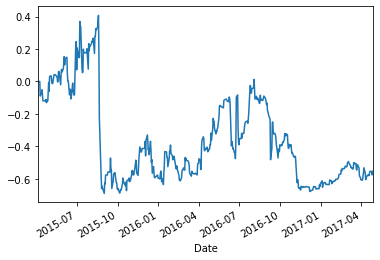

In [118]:
#Regular Ret as mean tracker
transaction_percentage = 0.015 #percentage is the transaction cost for the position
basket_size = 1#basket_sizes[np.argmax(cumrets)]
cl = history['Close']
ret = cl.pct_change()
rolling_ret = ret.rolling(window=3, axis=0).mean()
weights = - ret.add(- rolling_ret, axis=0)
weights = weights.mask(abs(weights).rank(axis=1, method='max', ascending=False) > basket_size, np.nan)
weights = weights.div(abs(weights).sum(axis=1), axis = 0)
dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True)
#dailyret.cumsum().plot()
CGR = (1 + dailyret).cumprod() - 1
CGR.plot()
ret_metrics(dailyret)

In [61]:
#Optimize window size
returns = [] 
#windows_sizes = [2 + i for i in range(100)]
#basket_sizes = [1 + i for i in range(100)]
args = []
for window in windows_sizes:
   # for basket_size in basket_sizes:
        transaction_percentage = 0.015 #percentage is the transaction cost for the position
        #basket_size = 3#basket_sizes[np.argmax(cumrets)]
        cl = history['Close']
        ret = cl.pct_change()
        rolling_ret = ret.rolling(window=window, axis=0).mean()
        weights = - ret.add(- rolling_ret, axis=0)
        weights = weights.mask(abs(weights).rank(axis=1, method='max', ascending=False) > basket_size, np.nan)
        weights = weights.div(abs(weights).sum(axis=1), axis = 0)
        dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True)
        #dailyret.cumsum().plot()
        CGR = (1 + dailyret).cumprod() - 1
        #CGR.plot()
        #ret_metrics(dailyret)
        args.append([basket_size, window])
        returns.append(CGR[-1])
optimal_basket_size, optimal_window = args[np.argmax(returns)]

CAGR: 13.15%, Anual Sharpe Ratio: 0.5039568482499401


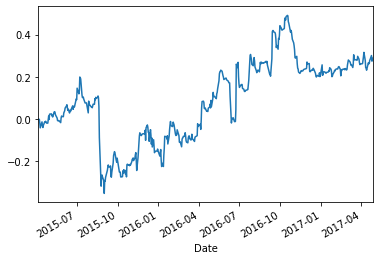

In [168]:
#Market ret as mean
optimal_basket_size = 20#basket_sizes[np.argmax(cumrets)]
cl = history['Close']
ret = cl.pct_change()

market_ret = ret.mean(axis=1) #unweighted
#ret_weights = cl.div(cl.sum(axis=1),axis=0)
#market_ret = (ret*ret_weights).sum(axis=1) # weighted

weights = - ret.add(- market_ret, axis=0)
weights = weights.mask(abs(weights).rank(axis=1, method='max', ascending=False) > optimal_basket_size, np.nan)
weights = weights.div(abs(weights).sum(axis=1), axis = 0)

dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True) 
#dailyret.cumsum().plot()

CGR = (1 + dailyret).cumprod() - 1
CGR.plot()
ret_metrics(dailyret)

CAGR: 119.0%, Anual Sharpe Ratio: 2.354429116103667


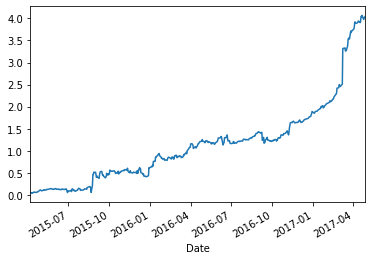

In [169]:
op = history['Open']
cl = history['Close']

ret = (op - cl.shift(1))/cl.shift(1)
market_ret = ret.mean(axis=1)
weights = - ret.add(- market_ret, axis=0)
weights = weights.mask(abs(weights).rank(axis=1, method='max', ascending=False) > optimal_basket_size, np.nan)
weights = weights.div(abs(weights).sum(axis=1), axis = 0)
dailyret = (weights*(cl-op)/op).sum(axis=1, skipna=True).div(abs(weights).sum(axis=1), axis=0) 

CGR = (1 + dailyret).cumprod() - 1
CGR.plot()
ret_metrics(dailyret)